# Advection-diffusion of a Gaussian on an interval

$$
\mathbb{S}
\begin{cases}
\Omega = [0, L_x] \\
u_0(x)=\exp\left(-\frac{(x - x_0)^2}{\sigma^2}\right) \\
u_{\text{N}}(x=0)=0 \\
u_{\text{D}}(x=L_x)=0 \\
\textbf{a}(\textbf{x})=x(L_x - x)\textbf{e}_x \\
\end{cases}
$$

In [ ]:
import numpy as np
from lucifex.mesh import interval_mesh
from lucifex.fdm import (
    CN, AM1, AB1, AB2, FiniteDifference, 
    FunctionSeries, ConstantSeries, finite_difference_order,
)
from lucifex.fem import Function, Constant
from lucifex.solver import ibvp, evaluation, extrema, BoundaryConditions
from lucifex.sim import run, Simulation
from lucifex.viz import plot_line, plot_twin_lines, plot_stacked_lines, save_figure
from lucifex.utils import nested_dict
from lucifex.pde.advection_diffusion import advection_diffusion


def create_simulation(
    Lx: float,
    Nx: int,
    dt: float,
    D_adv: FiniteDifference,
    D_diff: FiniteDifference,
) -> Simulation:
    order = finite_difference_order(D_adv, D_diff)
    mesh = interval_mesh(Lx, Nx)
    t = ConstantSeries(mesh, name='t', ics=0.0)
    dt = Constant(mesh, dt, name='dt')
    a = Function((mesh, 'P', 1, 1), name='a')
    a.interpolate(lambda x: (x[0] * (Lx - x[0]), ))
    d = Constant(mesh, 0.1, name='k')
    u = FunctionSeries((mesh, 'P', 1), name='u', order=order, store=1)
    u_bcs = BoundaryConditions(
        ('neumann', lambda x: x[0], 0.0),
        ('dirichlet', lambda x: x[0] - Lx, 0.0),
    )
    u_ics = lambda x: np.exp(-(x[0] - 0.2 * Lx)**2 / (0.001 * Lx))
    u_solver = ibvp(advection_diffusion, u_ics, u_bcs)(u, dt, a, d, D_adv, D_diff)
    uMinMax = ConstantSeries(mesh, name='uMinMax', shape=(2,), store=1)
    uMinMax_solver = evaluation(uMinMax, extrema)(u[0])
    solvers = [u_solver, uMinMax_solver]
    return Simulation(solvers, t, dt)


Lx = 2.0
Nx = 200
dt = 0.01

D_adv = AB2
D_diff_opts = (AB1, AM1, CN)
simulations = nested_dict((FiniteDifference, Simulation))

for D_diff in D_diff_opts:
    simulations[D_diff] = create_simulation(Lx, Nx, dt, D_adv, D_diff)
    
n_init = 5
n_stop = 150
for D_diff in D_diff_opts:
    run(simulations[D_diff], n_stop, n_init=n_init)

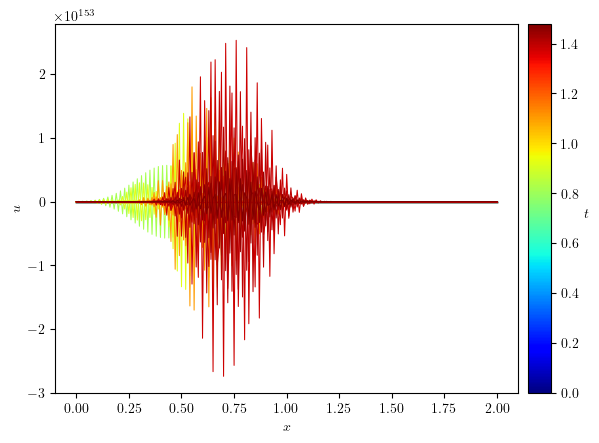

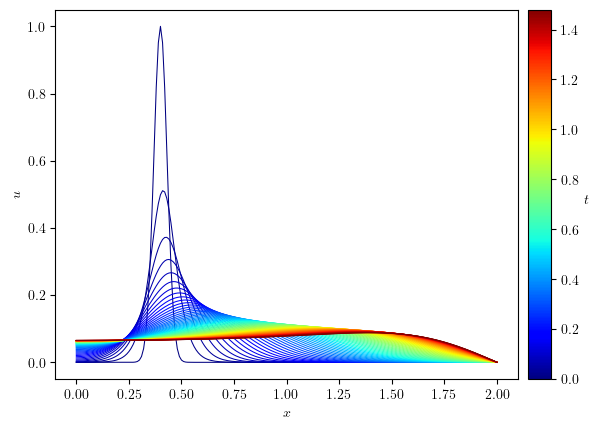

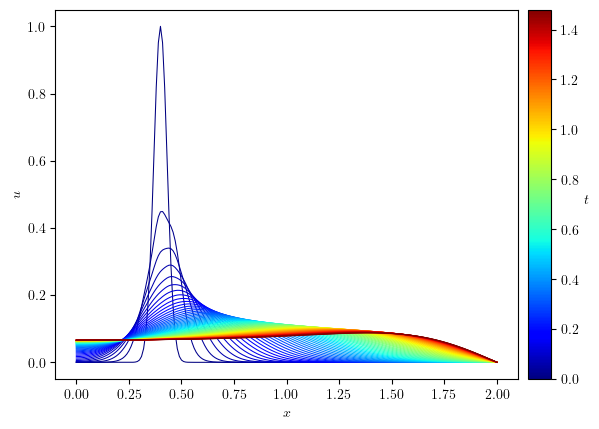

In [ ]:
for D_diff in D_diff_opts:
    u = simulations[D_diff]['u']
    slc = slice(0, None, 2)
    legend_labels=(min(u.time_series[slc]), max(u.time_series[slc]))
    fig, ax = plot_line(u.series[slc], legend_labels, '$t$', cyc='jet', x_label='$x$', y_label='$u$')
    save_figure(f'{repr(D_diff)}')(fig)

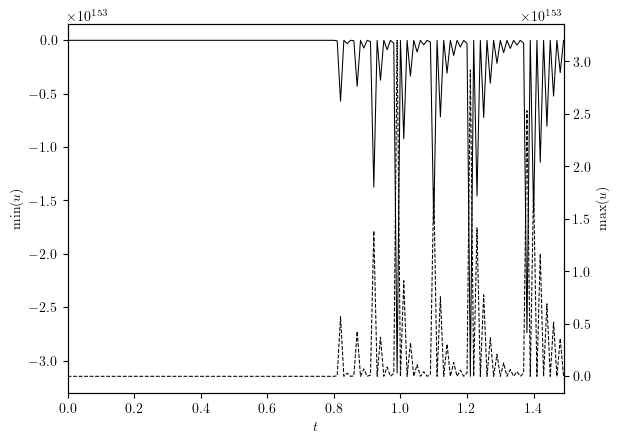

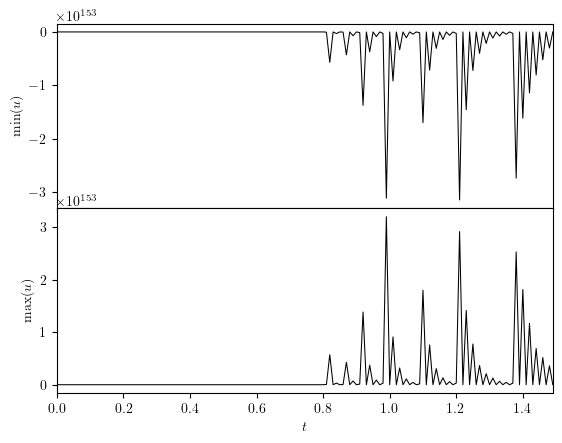

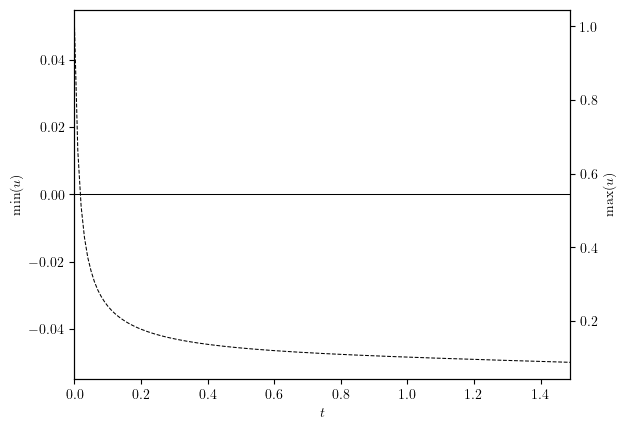

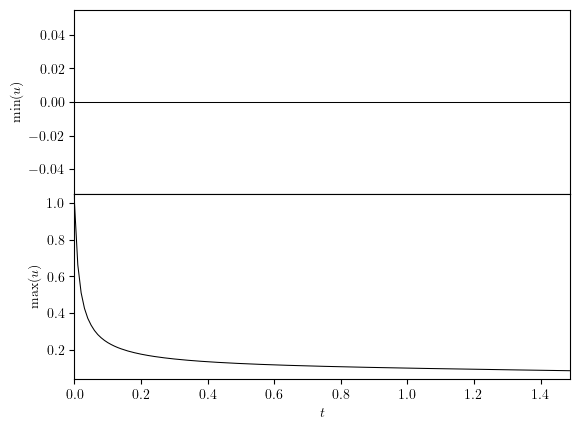

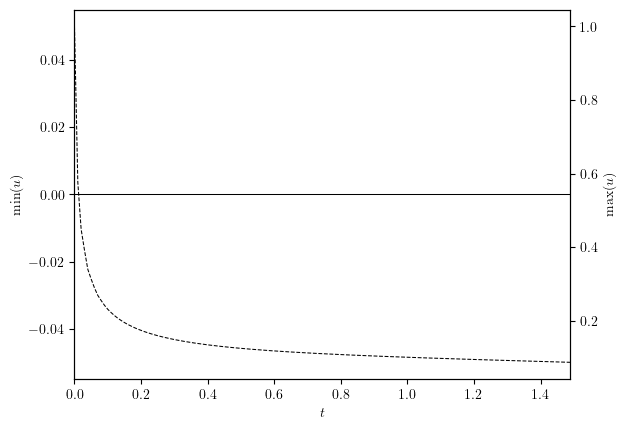

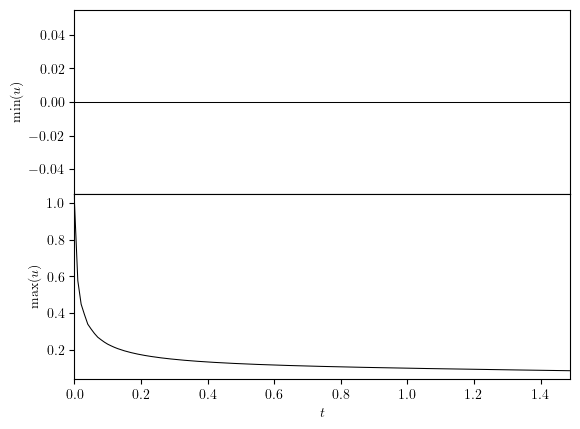

: 

In [ ]:
y_labels = ('$\min(u)$', '$\max(u)$')

for D_diff in D_diff_opts:
    uMinMax = simulations[D_diff]['uMinMax']
    uMin, uMax = uMinMax.sub(0), uMinMax.sub(1)
    plot_twin_lines(
        uMinMax.time_series,
        (uMin.value_series, uMax.value_series),
        y_labels,
        x_label='$t$',
    )
    plot_stacked_lines(
        [(uMin.time_series, uMin.value_series), (uMax.time_series, uMax.value_series)],
        '$t$',
        y_labels,
    )